# Classification de phrases avec word2vec

Le texte est toujours délicat à traiter. La langue est importante et plus le vocabulaire est étendu, plus il faut de données. Le problème qui suit est classique, on cherche à catégoriser des phrases en sentiment positif ou négatif. Ce pourrait être aussi classer des spams. Le problème le plus simple : une phrase, un label.

In [1]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [2]:
from jyquickhelper import add_notebook_menu
add_notebook_menu()

In [3]:
%matplotlib inline

## Les données

Elles proviennent de [Sentiment Labelled Sentences Data Set](https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences).

In [4]:
from papierstat.datasets import load_sentiment_dataset
df = load_sentiment_dataset()
df.head()

,sentance,sentiment,source
0,So there is no way for me to plug it in here i...,0,amazon_cells_labelled
1,"Good case, Excellent value.",1,amazon_cells_labelled
2,Great for the jawbone.,1,amazon_cells_labelled
3,Tied to charger for conversations lasting more...,0,amazon_cells_labelled
4,The mic is great.,1,amazon_cells_labelled


In [5]:
df.groupby(['source', 'sentiment']).count()

sentance
source                sentiment          
amazon_cells_labelled 0               500
                      1               500
imdb_labelled         0               500
                      1               500
yelp_labelled         0               500
                      1               500

On découpe en train and test.

In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df[["sentance"]], df['sentiment'])

## L'approche classique

[TF-IDF](https://fr.wikipedia.org/wiki/TF-IDF) est une approche très répandue lorsqu'il s'agit de convertir des phrases en features.

In [7]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(CountVectorizer(), TfidfTransformer())
pipe.fit(X_train['sentance'])
feat_train = pipe.transform(X_train['sentance'])
feat_train.shape

(2250, 4400)

In [8]:
feat_train.min(), feat_train.max()

(0.0, 1.0)

In [9]:
feat_test = pipe.transform(X_test['sentance'])
feat_test.shape

(750, 4400)

In [10]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=50)
clf.fit(feat_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [11]:
clf.score(feat_test, y_test)

0.788

In [12]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
score = clf.predict_proba(feat_test)
fpr, tpr, th = roc_curve(y_test, score[:, 1])

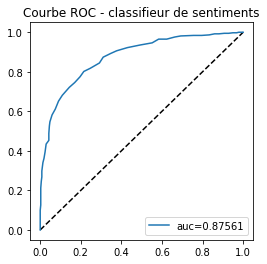

In [13]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 1, figsize=(4,4))
ax.plot([0, 1], [0, 1], 'k--')
aucf = auc(fpr, tpr)
ax.plot(fpr, tpr, label='auc=%1.5f' % aucf)
ax.set_title('Courbe ROC - classifieur de sentiments')
ax.legend();

## Les n-grammes

L'approche présentée ci-dessus ne tient pas compte de l'ordre des mots. Chaque phrase est convertie en un sac de mots (ou [bag of words](https://fr.wikipedia.org/wiki/Sac_de_mots)). Il est néanmoins possible de tenir compte de séquence plus ou moins longue.

In [14]:
# s'il faut télécharger des données
if False:
    import nltk
    nltk.download('punkt')

In [15]:
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
generated_ngrams = ngrams(word_tokenize(X_train.iloc[0,0]), 3, pad_left=True, pad_right=True)
list(generated_ngrams)[:7]

[(None, None, 'I'),
 (None, 'I', '*heart*'),
 ('I', '*heart*', 'this'),
 ('*heart*', 'this', 'place'),
 ('this', 'place', '.'),
 ('place', '.', None),
 ('.', None, None)]

[scikit-learn](http://scikit-learn.org/stable/modules/feature_extraction.html#limitations-of-the-bag-of-words-representation) permet d'essayer cette idée simplement.

In [16]:
pipe2 = make_pipeline(CountVectorizer(ngram_range=(1, 2)),
                      TfidfTransformer())
pipe2.fit(X_train['sentance'])
feat_train2 = pipe2.transform(X_train['sentance'])
feat_train2.shape

(2250, 20342)

Il y a plus de colonnes, on vérifie malgré tout que les features ressemblent à des couples de mots.

In [17]:
cl = pipe2.steps[0]
cl[1].get_feature_names()[:10]

['00',
 '10',
 '10 10',
 '10 and',
 '10 for',
 '10 grade',
 '10 minutes',
 '10 of',
 '10 on',
 '10 out']

C'est le cas.

In [18]:
feat_test2 = pipe2.transform(X_test['sentance'])

In [19]:
from sklearn.ensemble import RandomForestClassifier
clf2 = RandomForestClassifier(n_estimators=50)
clf2.fit(feat_train2, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [20]:
clf2.score(feat_test2, y_test)

0.7893333333333333

Cela n'améliore pas de façon significative. Il faudrait faire une cross-validation pour s'en assurer.

## Réduire les dimensions avec une ACP

C'est un moyen fréquemment utilisé pour réduire les dimensions. On choisit le modèle [TruncatedSVD](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD) plutôt que l'[ACP](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html#sklearn.decomposition.PCA) dont l'implémentation ne supporte pas les features sparses.

In [21]:
from sklearn.decomposition import TruncatedSVD
pipe_svd = make_pipeline(CountVectorizer(), TruncatedSVD(n_components=300))
pipe_svd.fit(X_train['sentance'])
feat_train_svd = pipe_svd.transform(X_train['sentance'])
feat_train_svd.shape

(2250, 300)

In [22]:
clf_svd = RandomForestClassifier(n_estimators=50)
clf_svd.fit(feat_train_svd, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [23]:
feat_test_svd = pipe_svd.transform(X_test['sentance'])
clf_svd.score(feat_test_svd, y_test)

0.6893333333333334

Et si on repart de TF-IDF :

In [24]:
pipe_svd_tfidf = make_pipeline(CountVectorizer(), 
                     TfidfTransformer(),
                     TruncatedSVD(n_components=300))
pipe_svd_tfidf.fit(X_train['sentance'])
feat_train_svd_tfidf = pipe_svd_tfidf.transform(X_train['sentance'])

clf_svd_tfidf = RandomForestClassifier(n_estimators=50)
clf_svd_tfidf.fit(feat_train_svd_tfidf, y_train)

feat_test_svd_tfidf = pipe_svd_tfidf.transform(X_test['sentance'])
clf_svd_tfidf.score(feat_test_svd_tfidf, y_test)

0.7213333333333334

C'est mieux mais cela reste moins bien que le *tf-idf* sans réduction de dimensions. Cela veut dire qu'il faut garder plus de dimensions.

## word2vec

[word2vec](https://en.wikipedia.org/wiki/Word2vec) est une sorte d'ACP non linéaire en ce sens qu'il réduit les dimensions. Il faut lire [Analyse en composantes principales (ACP) et Auto Encoders](http://www.xavierdupre.fr/app/mlstatpy/helpsphinx/c_ml/rn/rn_9_auto.html) pour comprendre le lien entre ACP, ACP non linéaire, réseaux de neurones diabolo et compression. *word2vec* est plus d'une ACP non linéaire car il prend en compte le contexte mais ne s'en éloigne pas tant que ce ça.

In [25]:
from gensim.utils import tokenize
sentance = [list(tokenize(s, deacc=True, lower=True)) for s in X_train['sentance']]
sentance[0]

['i', 'heart', 'this', 'place']

Les paramètres d'apprentissage du modèle [Word2Vec](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) ne sont pas toujours décrit de façon explicite.

In [26]:
from gensim.models import word2vec
model = word2vec.Word2Vec(sentance, size=300, window=20,
                          min_count=2, workers=1, iter=100)
model.corpus_count

2250

In [27]:
vocab = model.wv.vocab
list(vocab)[:5]

['i', 'heart', 'this', 'place', 'so']

In [28]:
model.save('trained_word2vec.bin')

Les dix premières coordonnées du vecteur associé au mot ``after``.

In [29]:
model.wv['after'].shape, model.wv['after'][:10]

((300,),
 array([-1.3176018 , -1.3460263 , -0.6796115 ,  0.5054756 , -1.3413163 ,
        -1.59745   ,  0.7052183 , -0.3164459 ,  0.18885957, -1.6917483 ],
       dtype=float32))

Lorsque le mot est inconnu :

In [30]:
try:
    model.wv['rrrrrrrr']
except KeyError as e:
    print(e)

"word 'rrrrrrrr' not in vocabulary"


Pour chaque phrase, on fait la somme des vecteurs associés aux mots qui la composent ou pas si le mot n'est pas dans le vocabulaire. Il y a probablement des fonctions déjà prêtes à l'emploi mais la documentation de [gensim](https://radimrehurek.com/gensim/index.html) n'était pas assez explicite et lire l'article [Efficient Estimation of Word Representations in Vector Space](https://arxiv.org/abs/1301.3781) puis celui-ci [Distributed Representations of Words and Phrases
and their Compositionality](https://arxiv.org/pdf/1310.4546.pdf).

In [31]:
import numpy

def get_vect(word, model):
    try:
        return model.wv[word]
    except KeyError:
        return numpy.zeros((model.vector_size,))

def sum_vectors(phrase, model):
    return sum(get_vect(w, model) for w in phrase)

def word2vec_features(X, model):
    feats = numpy.vstack([sum_vectors(p, model) for p in X])
    return feats

wv_train_feat = word2vec_features(X_train["sentance"], model)
wv_train_feat.shape

(2250, 300)

In [32]:
clfwv = RandomForestClassifier(n_estimators=50)
clfwv.fit(wv_train_feat, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [33]:
wv_test_feat = word2vec_features(X_test["sentance"], model)

In [34]:
clfwv.score(wv_test_feat, y_test)

0.56

La performance est nettement moindre et notamment moindre que la performance obtenue avec l'*ACP*. Il faudrait sans doute jouer avec les hyperparamètres de l'apprentissage ou réutiliser un model appris sur un corpus similaire aux données initiales mais nettement plus grand. On peut constater que la fonction de similarités ne retourne pas des résultat très intéressants.

In [35]:
words = list(sorted(model.wv.vocab))
words[:10]

['a',
 'ability',
 'able',
 'about',
 'above',
 'absolutely',
 'abysmal',
 'access',
 'accidentally',
 'accused']

In [36]:
subset = ['after', 'before', words[3], words[4], words[5]]
rows = []
for w in subset:
    for ww in subset:
        rows.append(dict(w1=w, w2=ww, d=model.wv.similarity(w, ww)))
import pandas
pandas.DataFrame(rows).pivot("w1", "w2", "d")

w2,about,above,absolutely,after,before
w1,,,,,
about,1.000000,0.212220,-0.027013,0.236452,0.256707
above,0.212220,1.000000,0.232470,0.179590,0.088611
absolutely,-0.027013,0.232470,1.000000,-0.014706,0.113076
after,0.236452,0.179590,-0.014706,1.000000,0.286992
before,0.256707,0.088611,0.113076,0.286992,1.000000


## word2vec pré-entraînés

Ce modèle est plus performant avec plus de données.
On peut télécharger des modèles pré-entraîner sur des données plus volumineuses :
 [Pre-Trained Word2Vec Models](https://github.com/jhlau/doc2vec) ou encore [Pre-trained word vectors of 30+ languages](https://github.com/Kyubyong/wordvectors). Ceux-ci sont plutôt gros (> 600 Mo). Le module *spacy* propose une version plus légère et mieux documentée [Word Vectors and Semantic Similarity](https://spacy.io/usage/vectors-similarity) avec les données [en_core_web_md](https://github.com/explosion/spacy-models/releases).

In [37]:
import spacy
from spacy.cli import download
# download("en_core_web_md")  # ça ne marche pas toujours

In [38]:
import os
version = "2.1.0"
unzip_dest = 'en_core_web_md-{0}.tar/dist/en_core_web_md-{0}/en_core_web_md/en_core_web_md-{0}'.format(version)
if not os.path.exists(unzip_dest):
    from pyquickhelper.pycode import is_travis_or_appveyor
    if not is_travis_or_appveyor():
        # On le fait seulement si ce n'est pas un test d'intégration continue.
        url = "https://github.com/explosion/spacy-models/releases/download/en_core_web_md-%s/" % version
        name = "en_core_web_md-%s.tar.gz" % version
        print("Téléchargement de ", name)
        from pyensae.datasource import download_data
        unzipped = download_data(name, url=url, fLOG=print)
        unzip_dest = os.path.split(unzipped[0])[0]
        unzip_dest = "en_core_web_md-{0}/en_core_web_md/en_core_web_md-{0}".format(version)
        print("Found", unzip_dest)
        
if os.path.exists(unzip_dest):
    print("Chargement des données par spacy.")
    nlp = spacy.load(unzip_dest)
    continue_wv = True
else:
    continue_wv = False
    print('Pas de données on passe la suite.')

Téléchargement de  en_core_web_md-2.1.0.tar.gz
Found en_core_web_md-2.1.0/en_core_web_md/en_core_web_md-2.1.0
Chargement des données par spacy.


In [39]:
if continue_wv:
    tokens = nlp('after before italian films about above absolutely')
    rows = []
    for token1 in tokens:
        for token2 in tokens:
            sim = model.wv.similarity(token1.text, token2.text)
            rows.append(dict(w1=token1.text, w2=token2.text, d=sim))
pandas.DataFrame(rows).pivot("w1", "w2", "d")

w2,about,above,absolutely,after,before,films,italian
w1,,,,,,,
about,1.000000,0.212220,-0.027013,0.236452,0.256707,0.299878,-0.148594
above,0.212220,1.000000,0.232470,0.179590,0.088611,0.216481,0.280013
absolutely,-0.027013,0.232470,1.000000,-0.014706,0.113076,-0.064618,-0.037417
after,0.236452,0.179590,-0.014706,1.000000,0.286992,0.248450,0.093066
before,0.256707,0.088611,0.113076,0.286992,1.000000,0.065779,-0.022599
films,0.299878,0.216481,-0.064618,0.248450,0.065779,1.000000,0.208975
italian,-0.148594,0.280013,-0.037417,0.093066,-0.022599,0.208975,1.000000


In [40]:
if continue_wv:
    print(tokens[0].vector.shape, tokens[0].vector[:10])

(300,) [ 0.2069    0.44321  -0.12522  -0.017724 -0.064277 -0.44308   0.014019
 -0.10119   0.22699   3.1689  ]


In [41]:
import numpy

def spacy_sum_vectors(phrase, nlp):
    dec = nlp(phrase)
    return sum(w.vector for w in dec)

def spacy_word2vec_features(X, nlp):
    feats = numpy.vstack([spacy_sum_vectors(p, nlp) for p in X])
    return feats

if continue_wv:
    try:
        wv_train_feat2 = spacy_word2vec_features(X_train["sentance"], nlp)
        print(wv_train_feat2.shape)
    except ValueError as e:
        print(e)
        continue_wv = False

(2250, 300)


In [42]:
if continue_wv:
    clfwv2 = RandomForestClassifier(n_estimators=50)
    clfwv2.fit(wv_train_feat2, y_train)

In [43]:
if continue_wv:
    wv_test_feat2 = spacy_word2vec_features(X_test["sentance"], nlp)

In [44]:
if continue_wv:
    print(clfwv2.score(wv_test_feat2, y_test))

0.7786666666666666


C'est un peu mieux mais un peu plus coûteux en temps de calcul mais même sans entraînement, le modèle obtenu est plus performant avec 300 dimensions que celui obtenu avec l'ACP. Le corpus extérieur au problème apporte de la valeur.